# Step 1: Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 2: Download and prepare Cats vs Dogs dataset

In [2]:
print("Downloading Cats vs Dogs dataset...")
_URL = 'https://download.mlcc.google.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
PATH = os.path.join(
    os.path.dirname(path_to_zip),
    'cats_and_dogs_extracted',
    'cats_and_dogs_filtered'
)

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print("Training cats:", len(os.listdir(train_cats_dir)))
print("Training dogs:", len(os.listdir(train_dogs_dir)))
print("Validation cats:", len(os.listdir(validation_cats_dir)))
print("Validation dogs:", len(os.listdir(validation_dogs_dir)))

Training cats: 1000
Training dogs: 1000
Validation cats: 500
Validation dogs: 500


# Step 3: Create data generators with augmentation

In [4]:
IMG_SIZE = (160, 160)          # VGG16 usually expects 224×224, but 160 is faster for demo
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Step 4: Load pre-trained VGG16 (without top classification layers)

In [5]:
base_model = VGG16(weights='imagenet',
                   include_top=False,           # remove final dense layers
                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Freeze the base model (very important in transfer learning)
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Step 4: Load pre-trained VGG16 (without top classification layers)

In [6]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),          # better than Flatten for conv base
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')     # binary classification → sigmoid
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Step 6: Compile the model

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Step 7: Train the top layers first (feature extractor frozen)

In [13]:
print("\nPhase 1: Training top layers only...")
history_phase1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    verbose=1
)



Phase 1: Training top layers only...
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9777 - loss: 0.0545 - val_accuracy: 0.9700 - val_loss: 0.0818
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.9809 - loss: 0.0504 - val_accuracy: 0.9620 - val_loss: 0.1067
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.9854 - loss: 0.0344 - val_accuracy: 0.9570 - val_loss: 0.1346
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.9846 - loss: 0.0437 - val_accuracy: 0.9750 - val_loss: 0.0806
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 364ms/step - accuracy: 0.9944 - loss: 0.0258 - val_accuracy: 0.9630 - val_loss: 0.1002
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9982 - loss: 0.0144 - val_accuracy: 0.9640 - val_loss: 0.1184
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9822 - loss: 0.0450 - val_accuracy: 0.9670 - val_loss: 0.0835
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accu

# Step 8: Unfreeze some layers and fine-tune (optional Phase 2)

In [14]:
print("\nUnfreezing last few conv blocks for fine-tuning...")
base_model.trainable = True
# Freeze all layers except the last 4 blocks (example)
for layer in base_model.layers[:-16]:
    layer.trainable = False
# Re-compile with lower learning rate (very important!)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("Phase 2: Fine-tuning...")
history_phase2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    verbose=1
)



Unfreezing last few conv blocks for fine-tuning...
Phase 2: Fine-tuning...
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 443ms/step - accuracy: 0.9900 - loss: 0.0246 - val_accuracy: 0.9740 - val_loss: 0.1226
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 361ms/step - accuracy: 0.9915 - loss: 0.0236 - val_accuracy: 0.9720 - val_loss: 0.1315
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.9923 - loss: 0.0229 - val_accuracy: 0.9700 - val_loss: 0.1212
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9959 - loss: 0.0113 - val_accuracy: 0.9710 - val_loss: 0.1206
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9987 - loss: 0.0088 - val_accuracy: 0.9810 - val_loss: 0.0951
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9960 - loss: 0.0122 - val_accuracy: 0.9780 - val_loss: 0.0941
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9946 - loss: 0.0140 - val_accuracy: 0.9740 - val_loss: 0.0777
Epoch 8/20
63/63 ━━━━

# Step 9: Plot training history

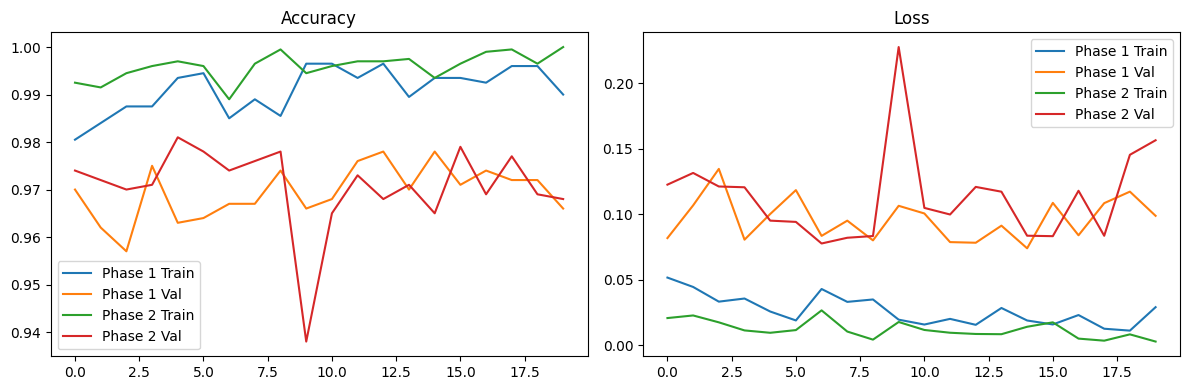

In [15]:
def plot_history(histories, titles):
    plt.figure(figsize=(12, 4))
    for i, hist in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{titles[i]} Val')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_loss'], label=f'{titles[i]} Val')
        plt.title('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()
plot_history([history_phase1, history_phase2], ['Phase 1', 'Phase 2'])


# Step 10: Evaluate final model


In [16]:
loss, acc = model.evaluate(validation_generator, verbose=0)
print(f"\nFinal validation accuracy: {acc:.4f} ({acc*100:.2f}%)")
# Optional: Save model
# model.save("vgg16_cats_dogs_transfer.h5")
print("Practical 2 completed.")


Final validation accuracy: 0.9680 (96.80%)
Practical 2 completed.
